## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [2]:
import numpy as np
import keras

from keras.applications.resnet50 import ResNet50

Using plaidml.keras.backend backend.


In [3]:
dataset_path = "../../LEGO_brick_images_v1/"
dataset_output = "./output"

In [4]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input #required to format input

train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    height_shift_range=0.1,
    width_shift_range=0.1,
    preprocessing_function=preprocess_input
)
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), target_size=(200,200), shuffle=True, class_mode='categorical')


print(len(train_generator.class_indices))

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anto\anaconda3\envs\lego_

In [6]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(200,200,3))

#freeze layers for first time training
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(1024)(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(512)(top_model)
top_model = Dense(len(train_generator.class_indices), activation="softmax")(top_model)

model = Model(inputs = base_model.inputs, outputs = top_model)

model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling

In [7]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10, #might need tweaking to prevent overfit
    verbose=1,
    mode='auto',
    restore_best_weights=True
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduceLR,earlystop]

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [8]:
from keras.optimizers import Adam

opt = Adam(lr=0.0005)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

#first train 
history = model.fit_generator(
    train_generator, 
    steps_per_epoch  = None, 
    validation_data  = validation_generator,
    validation_steps = None,
    epochs = 100, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/100
140/140 [==============================] - 160s 1s/step - loss: 26.3152 - acc: 0.6341 - val_loss: 5.7316 - val_acc: 0.8720

Epoch 00001: val_loss improved from inf to 5.73162, saving model to ./base.model
Epoch 2/100
140/140 [==============================] - 120s 860ms/step - loss: 16.2578 - acc: 0.7788 - val_loss: 9.6144 - val_acc: 0.8892

Epoch 00002: val_loss did not improve from 5.73162
Epoch 3/100
140/140 [==============================] - 122s 870ms/step - loss: 14.8009 - acc: 0.8226 - val_loss: 7.2122 - val_acc: 0.9112

Epoch 00003: val_loss did not improve from 5.73162
Epoch 4/100
140/140 [==============================] - 120s 858ms/step - loss: 15.6095 - acc: 0.8358 - val_loss: 10.6154 - val_acc: 0.8814

Epoch 00004: val_loss did not improve from 5.73162
Epoch 5/100
140/140 [==============================] - 120s 857ms/step - loss: 14.4801 - acc: 0.8565 - val_loss: 5.4496 - val_acc: 0.9378

Epoch 00005: val_loss improved from 5.73162 to 5.44958, saving model to .

In [9]:
#fine tune by unlocking training for only last conv block and using a low learning rate
for layer in base_model.layers[:-4]:
    layer.trainable = True

opt = Adam(lr=1e-5)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

#train again
history = model.fit_generator(
    train_generator, 
    steps_per_epoch  = None, 
    validation_data  = validation_generator,
    validation_steps = None,
    epochs = 10, 
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

Epoch 1/10
INFO:plaidml:Analyzing Ops: 133 of 565 operations complete
140/140 [==============================] - 471s 3s/step - loss: 2.6461 - acc: 0.9545 - val_loss: 2.1920 - val_acc: 0.9577

Epoch 00001: val_loss did not improve from 1.17231
Epoch 2/10
140/140 [==============================] - 402s 3s/step - loss: 1.5070 - acc: 0.9581 - val_loss: 1.6558 - val_acc: 0.9634

Epoch 00002: val_loss did not improve from 1.17231
Epoch 3/10
140/140 [==============================] - 422s 3s/step - loss: 1.8193 - acc: 0.9565 - val_loss: 1.8765 - val_acc: 0.9650

Epoch 00003: val_loss did not improve from 1.17231
Epoch 4/10
140/140 [==============================] - 410s 3s/step - loss: 1.3871 - acc: 0.9566 - val_loss: 2.1368 - val_acc: 0.9556

Epoch 00004: val_loss did not improve from 1.17231
Epoch 5/10
140/140 [==============================] - 425s 3s/step - loss: 1.3221 - acc: 0.9629 - val_loss: 0.9847 - val_acc: 0.9697

Epoch 00005: val_loss improved from 1.17231 to 0.98473, saving mode

In [10]:
import matplotlib.pyplot as plt

def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

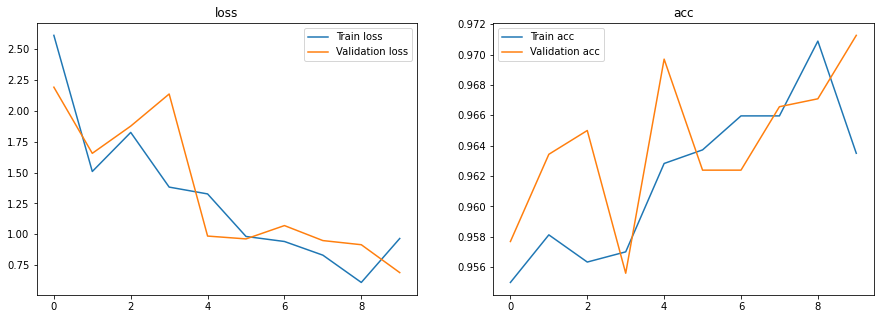

In [11]:
show_final_history(history)

We can try and test the model on random new images

In [12]:
import cv2
from keras.applications.vgg16 import preprocess_input #required to format input

image_path = "../../LEGO_brick_images_v1/3673 Peg 2M/0099.png"
image = cv2.imread(image_path)

from numpy import array
json_file = open("./model/lego.json", "r")
json_model = json_file.read()
json_file.close()

loaded_model = keras.models.model_from_json(json_model)
loaded_model.load_weights("./model/lego_weights.h5")

loaded_model.summary()
image = np.expand_dims(image, axis=0)
image = preprocess_input(image) #before testing we have to convert the image

prediction = loaded_model.predict(image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [13]:
print(prediction[0])
print(prediction[0].tolist().index(max(prediction[0])))
print(list(validation_generator.class_indices.keys())[prediction[0].tolist().index(max(prediction[0]))])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
12
3673 Peg 2M
